# Data Preprocessing

## Imports and Setup

In [1]:
import os
import sys
sys.path.insert(0, "../utils/")
import geoutils
import cnn_utils
import config

import pandas as pd
import numpy as np
import geopandas as gpd

pd.set_option('mode.chained_assignment', None)
%load_ext autoreload
%autoreload 2

## Parameters

In [2]:
exp_config = '../configs/datagen/datagen_DOM.yaml'
c = config.create_config(exp_config, prefix='.')
rgb_path, lidar_path = geoutils.get_image_dirs(config=c)

## Generate Raw Dataset

### Load Raw Building Footprints Datasets

In [3]:
bldgs_file = f"building_footprints_{c['aoi']}.gpkg"
bldgs_path = os.path.join(c['vectors_dir'], bldgs_file)
bldgs = gpd.read_file(bldgs_path).reset_index(drop=True)
bldgs["roof_type"] = None
bldgs["roof_material"] = None
bldgs["roof_condition"] = None
bldgs["UID"] = bldgs.index
print(f"Dimensions: {bldgs.shape}")
if c['aoi'] == 'DOM': print(bldgs.Layer.value_counts(normalize=True))
bldgs.head(3)

Dimensions: (50405, 7)
Layer
BLD_GEN_OUTLINE               0.671977
BLD_OUTBUILDING               0.169249
BLD_RUINS                     0.135483
BLD_UNDER_CONSTRUCT           0.009582
BLD_RESIDENTIAL_TRAILER       0.004742
BLD_OUTBUILDING_GREENHOUSE    0.003452
BLD_OUTBUILDING_GARAGE        0.002877
BLD_INDUSTRIAL_TANK           0.002639
Name: proportion, dtype: float64


Layer   Elevation   
0  BLD_OUTBUILDING  100.664513  \
1  BLD_GEN_OUTLINE   68.508759   
2  BLD_GEN_OUTLINE   67.150764   

                                            geometry roof_type roof_material   
0  MULTIPOLYGON Z (((675912.759 1682212.635 99.94...      None          None  \
1  MULTIPOLYGON Z (((675731.846 1682256.863 68.50...      None          None   
2  MULTIPOLYGON Z (((675723.312 1682258.156 67.15...      None          None   

  roof_condition  UID  
0           None    0  
1           None    1  
2           None    2

### Load Geoboundaries

In [4]:
geoboundaries_file = f"geoboundaries_{c['aoi']}.geojson"
geoboundaries_path = os.path.join(c['vectors_dir'], geoboundaries_file)
geoboundaries = gpd.read_file(geoboundaries_path)
geoboundaries = geoboundaries.to_crs(bldgs.crs)
print(f"Dimensions: {geoboundaries.shape}")
geoboundaries.head(3)

Dimensions: (10, 6)


shapeName shapeISO                  shapeID shapeGroup shapeType   
0   Saint Andrew    DM-02  96108325B90990394709253        DMA      ADM1  \
1   Saint Joseph    DM-06  96108325B58679667985230        DMA      ADM1   
2  Saint Patrick    DM-09  96108325B45209249151807        DMA      ADM1   

                                            geometry  
0  POLYGON ((685253.952 1716483.585, 685238.183 1...  
1  POLYGON ((671752.163 1714477.337, 670884.687 1...  
2  POLYGON ((682161.205 1694983.709, 682176.267 1...

### Join Building Footprints with Geoboundaries

In [5]:
boundaries = geoboundaries[['shapeName', 'geometry']]
boundaries.columns = ['shape_name', 'geometry']
bldgs_merged = bldgs.sjoin(
    boundaries,
    how='left',
    predicate='intersects'
).drop(['index_right'], axis=1)
print(f"Dimensions: {bldgs_merged.shape}")
bldgs_merged.head(3)

Dimensions: (50427, 8)


Layer   Elevation   
0  BLD_OUTBUILDING  100.664513  \
1  BLD_GEN_OUTLINE   68.508759   
2  BLD_GEN_OUTLINE   67.150764   

                                            geometry roof_type roof_material   
0  MULTIPOLYGON Z (((675912.759 1682212.635 99.94...      None          None  \
1  MULTIPOLYGON Z (((675731.846 1682256.863 68.50...      None          None   
2  MULTIPOLYGON Z (((675723.312 1682258.156 67.15...      None          None   

  roof_condition  UID  shape_name  
0           None    0  Saint Mark  
1           None    1  Saint Mark  
2           None    2  Saint Mark

### Save Blank Dataset to File

In [7]:
columns = ['UID','shape_name', 'geometry', 'roof_type', 'roof_material', 'roof_condition']
filename = f"building_footprints_annotated_{c['aoi']}.gpkg"
filepath = os.path.join(c['vectors_dir'], c['version'], filename)
#bldgs_merged[columns].to_file(filepath, driver='GPKG')
bldgs_merged[columns].head(3)

UID  shape_name                                           geometry   
0    0  Saint Mark  MULTIPOLYGON Z (((675912.759 1682212.635 99.94...  \
1    1  Saint Mark  MULTIPOLYGON Z (((675731.846 1682256.863 68.50...   
2    2  Saint Mark  MULTIPOLYGON Z (((675723.312 1682258.156 67.15...   

  roof_type roof_material roof_condition  
0      None          None           None  
1      None          None           None  
2      None          None           None

## Inspect Data Annotations

In [4]:
bldgs = geoutils.get_annotated_bldgs(c)
tiles_file = f"annotation_tiles_{c['aoi']}.gpkg"
tiles_path = os.path.join(c['vectors_dir'], c['version'], tiles_file)
tiles = gpd.read_file(tiles_path)
tiles = tiles[tiles.status == 'COMPLETE']
print(f"Number of annotated tiles {tiles.shape}")
bldgs.head(3)

INFO:root:Dimensions: (50345, 8)
INFO:root:Dimensions (non-null): (6170, 8)
INFO:root:roof_material
HEALTHY_METAL      1439
INCOMPLETE         1227
CONCRETE_CEMENT    1192
IRREGULAR_METAL    1186
BLUE_TARP          1126
Name: count, dtype: int64
INFO:root:roof_type
GABLE      2046
FLAT       1620
HIP        1364
NO_ROOF    1140
Name: count, dtype: int64


Number of annotated tiles (52, 7)


UID   Elevation            Layer roof_type roof_material  roof_condition   
0    0  100.664513  BLD_OUTBUILDING       NaN           NaN             NaN  \
1    1   68.508759  BLD_GEN_OUTLINE       NaN           NaN             NaN   
2    2   67.150764  BLD_GEN_OUTLINE       NaN           NaN             NaN   

   shape_name                                           geometry  
0  Saint Mark  MULTIPOLYGON Z (((675912.759 1682212.635 99.94...  
1  Saint Mark  MULTIPOLYGON Z (((675731.846 1682256.863 68.50...  
2  Saint Mark  MULTIPOLYGON Z (((675723.312 1682258.156 67.15...

## Inspect Image Crops

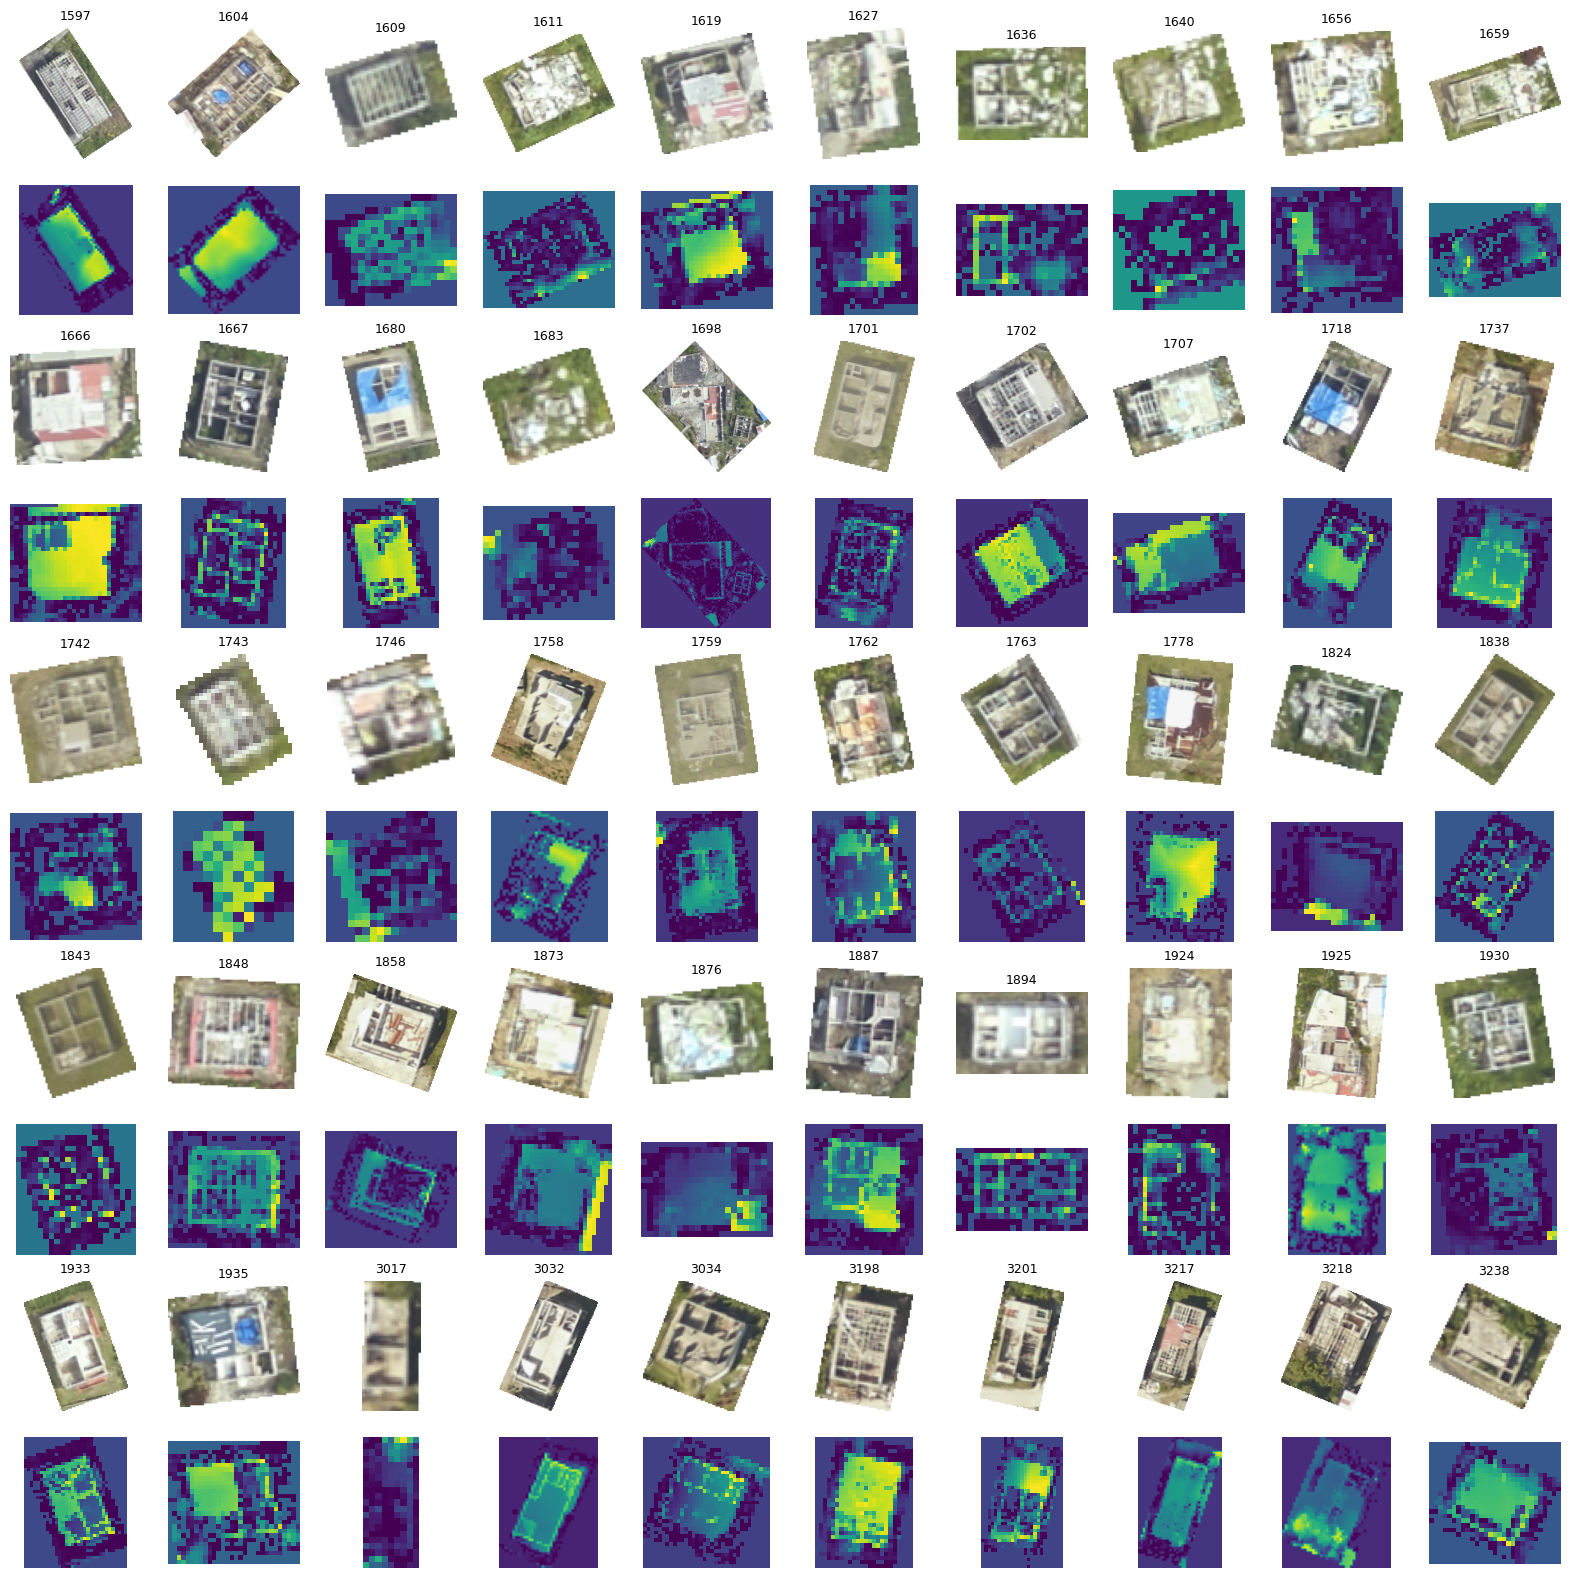

In [10]:
geoutils.inspect_image_crops(
    bldgs, 
    column='roof_material', 
    value='INCOMPLETE',
    rgb_path=rgb_path, 
    lidar_path=lidar_path, 
    aoi=c['aoi'],
    index=50, 
    n_rows=5,
    n_cols=10,
    figsize=(20,20)
)

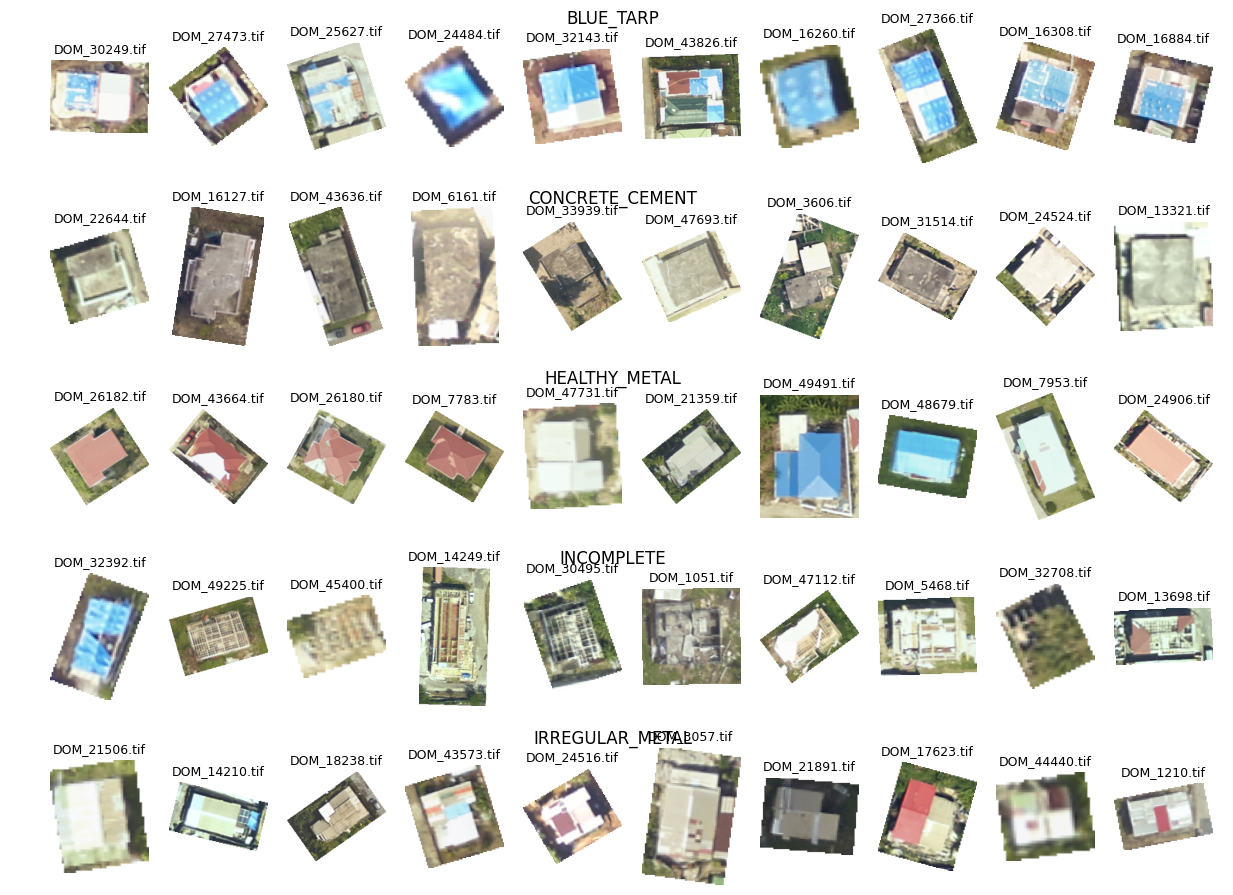

In [6]:
n_samples = 10
geoutils.visualize_image_crops(rgb_path, 'roof_material', n_samples=10, n_channels=3, figsize=(15,9))

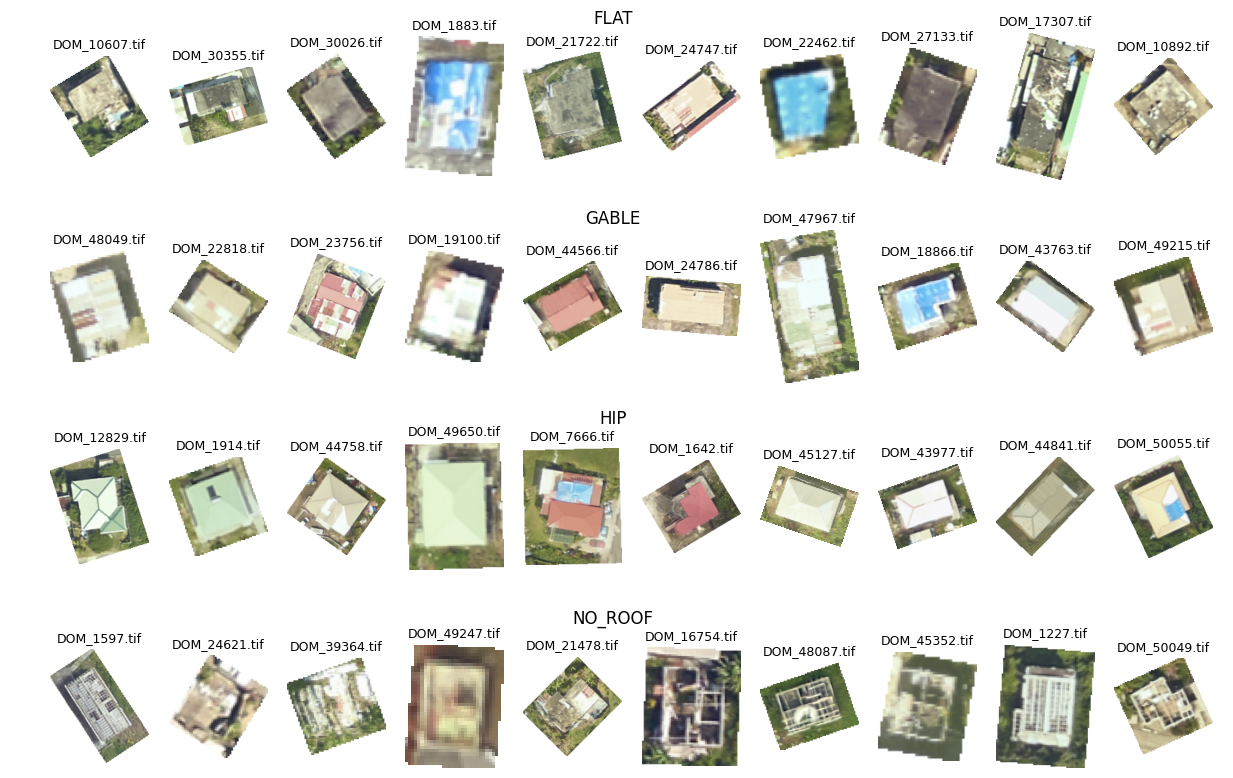

In [7]:
geoutils.visualize_image_crops(rgb_path, 'roof_type', n_samples=10, n_channels=3, figsize=(15,8))

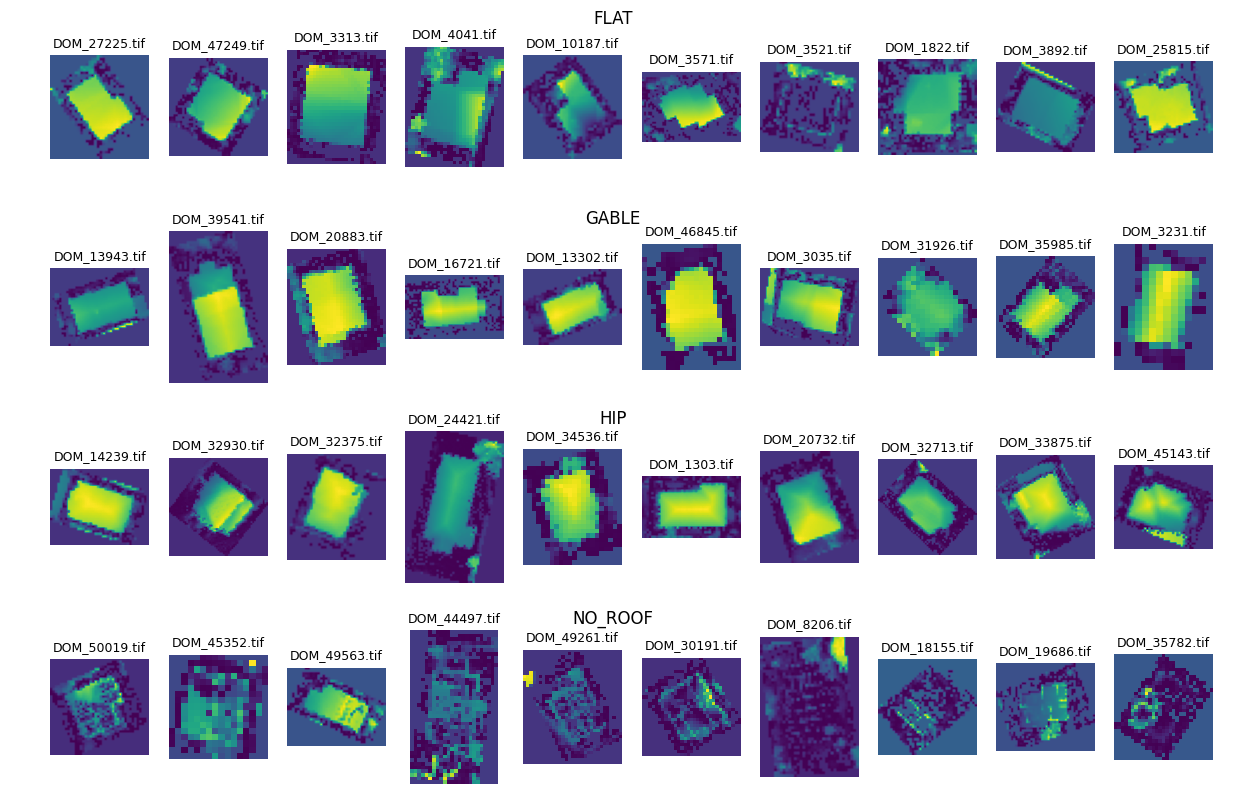

In [8]:
geoutils.visualize_image_crops(lidar_path, 'roof_type', n_samples=10, n_channels=1, figsize=(15,8))